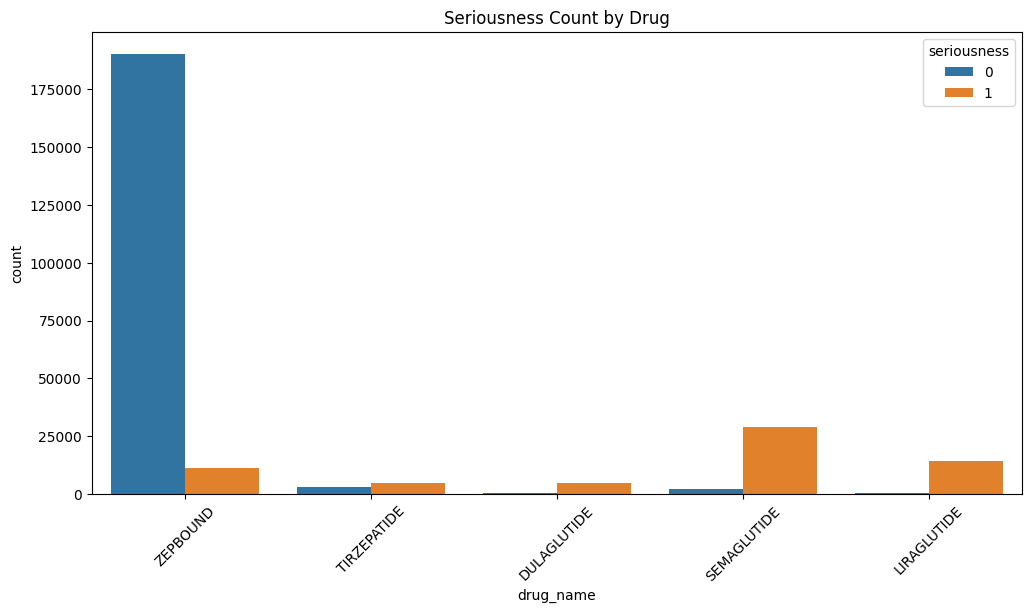

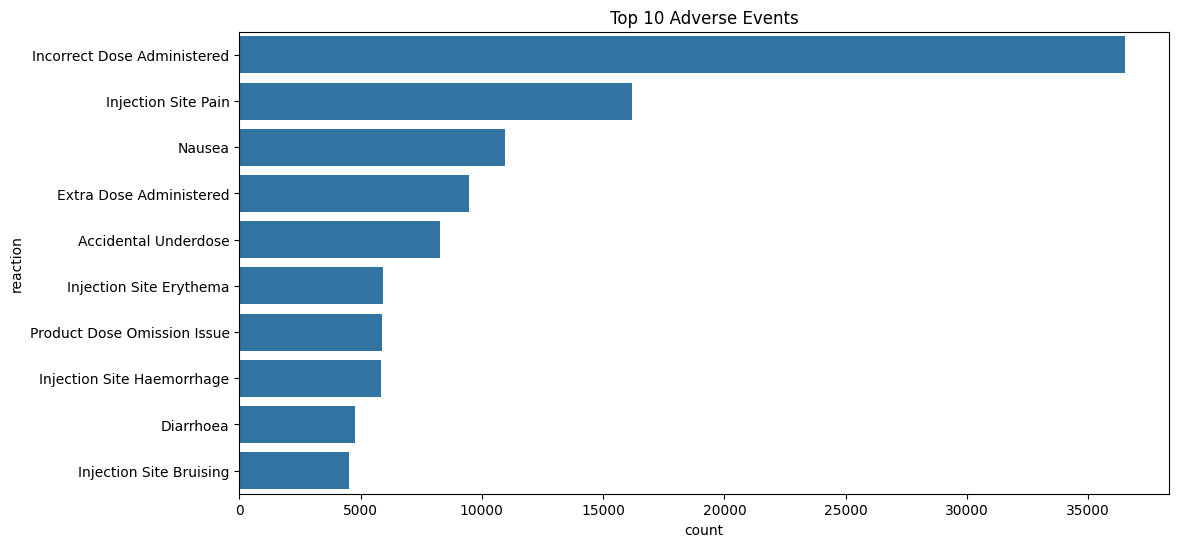

In [4]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
# ensure repo root is on sys.path so we can import data_engineer package
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_engineer.config import DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME

# 1. Connect DB
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
df = pd.read_sql("SELECT * FROM glp1_clean", engine)

# 2. Basic Visualization
plt.figure(figsize=(12, 6))

# ดูสัดส่วนความรุนแรงแยกตามยา
sns.countplot(data=df, x='drug_name', hue='seriousness')
plt.title("Seriousness Count by Drug")
plt.xticks(rotation=45)
plt.show()

# ดู Top 10 อาการข้างเคียง
top_reactions = df['reaction'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['reaction'].isin(top_reactions)], y='reaction', order=top_reactions)
plt.title("Top 10 Adverse Events")
plt.show()

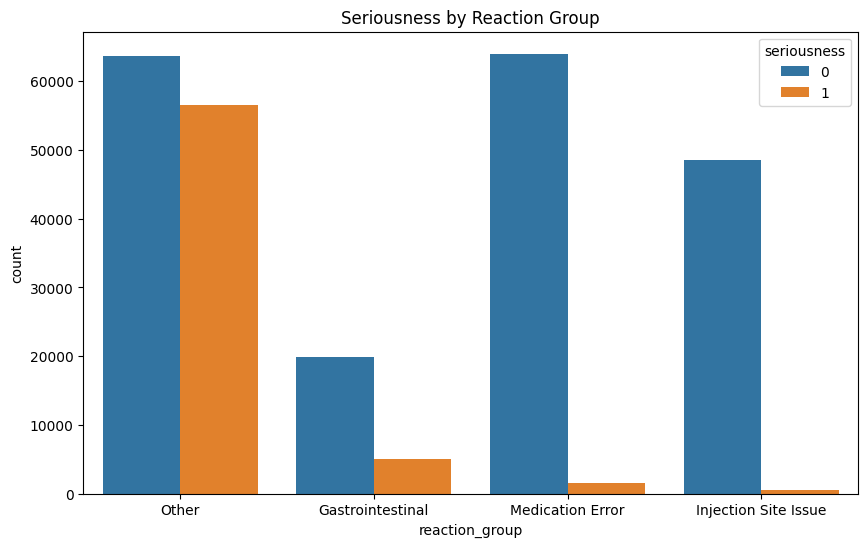

In [5]:
# สร้างฟังก์ชันจัดกลุ่ม Reaction
def categorize_reaction(val):
    val = str(val).lower()
    
    # 1. กลุ่ม Human Error / การใช้ยาผิด
    if any(x in val for x in ['dose', 'administered', 'omission', 'schedule', 'product use']):
        return 'Medication Error'
    
    # 2. กลุ่มปัญหาจุดฉีด (Injection Site)
    elif 'injection site' in val:
        return 'Injection Site Issue'
    
    # 3. กลุ่มทางเดินอาหาร (GI) - ผลข้างเคียงหลักของยากลุ่ม GLP-1
    elif any(x in val for x in ['nausea', 'vomit', 'diarrhoea', 'stomach', 'abdominal']):
        return 'Gastrointestinal'
    
    # 4. อื่นๆ
    else:
        return 'Other'

# Apply สร้าง Column ใหม่
df['reaction_group'] = df['reaction'].apply(categorize_reaction)

# ลองพลอตกราฟใหม่ ดูสัดส่วนความรุนแรงตามกลุ่ม
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='reaction_group', hue='seriousness')
plt.title("Seriousness by Reaction Group")
plt.show()

In [6]:
from sklearn.utils import resample

# --- Step 1: Filtering for Clinical Safety ---
# เก็บเฉพาะอาการที่เป็นโรค หรือความผิดปกติทางร่างกายจริง (Gastro + Other)
clinical_df = df[df['reaction_group'].isin(['Gastrointestinal', 'Other'])].copy()

print(f"Original Row Count: {len(df)}")
print(f"Clinical Only Row Count: {len(clinical_df)}")
print("-" * 30)

# --- Step 2: Undersampling (Option B) ---
# แยกข้อมูลเป็น 2 กลุ่ม
df_majority = clinical_df[clinical_df.seriousness == 0] # Non-Serious (เยอะกว่า)
df_minority = clinical_df[clinical_df.seriousness == 1] # Serious (น้อยกว่า)

print(f"Before Balancing -> Non-Serious: {len(df_majority)}, Serious: {len(df_minority)}")

# สุ่มตัด Majority ให้เหลือเท่ากับ Minority
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # ไม่ใส่คืน (ตัดแล้วตัดเลย)
                                   n_samples=len(df_minority), # เอาเท่ากับจำนวน Serious
                                   random_state=42)  # ล็อคผลให้เหมือนเดิมทุกครั้ง

# รวมร่างกลับ
df_balanced = pd.concat([df_majority_downsampled, df_minority])

print(f"After Balancing  -> Non-Serious: {len(df_majority_downsampled)}, Serious: {len(df_minority)}")
print(f"Total Balanced Data: {len(df_balanced)}")
print("-" * 30)

# --- Step 3: Feature Engineering (Ready for AI) ---
# แปลงข้อมูล Category เป็นตัวเลข (One-Hot Encoding)
# เราจะเลือกเฉพาะ Feature ที่น่าจะมีผล: Age, Sex, Drug Name, Drug Route
model_data = df_balanced[['age_years', 'sex', 'drug_name', 'seriousness']]

# ทำ One-Hot Encoding (แปลง Male/Female เป็น 0/1, ชื่อยาเป็น 0/1)
model_data = pd.get_dummies(model_data, columns=['sex', 'drug_name'], drop_first=True)

print("Final Data for Model (First 5 rows):")
display(model_data.head())

Original Row Count: 259740
Clinical Only Row Count: 145158
------------------------------
Before Balancing -> Non-Serious: 83592, Serious: 61566
After Balancing  -> Non-Serious: 61566, Serious: 61566
Total Balanced Data: 123132
------------------------------
Final Data for Model (First 5 rows):


,age_years,seriousness,sex_M,sex_Unknown,drug_name_LIRAGLUTIDE,drug_name_SEMAGLUTIDE,drug_name_TIRZEPATIDE,drug_name_ZEPBOUND
31629,39.0,0,False,False,False,False,False,True
66211,53.0,0,False,False,False,False,False,True
23827,54.0,0,False,False,False,False,False,True
122825,51.0,0,False,True,False,False,False,True
161690,59.0,0,False,False,False,False,False,True


Training Set: (98505, 7)
Test Set:     (24627, 7)
------------------------------
🤖 Training Logistic Regression...
   -> Accuracy: 0.8818
   -> ROC-AUC:  0.8957
------------------------------
🤖 Training Random Forest...
   -> Accuracy: 0.8818
   -> ROC-AUC:  0.8957
------------------------------
🤖 Training Random Forest...
   -> Accuracy: 0.8920
   -> ROC-AUC:  0.9360
------------------------------
🤖 Training XGBoost...
   -> Accuracy: 0.8909
   -> ROC-AUC:  0.9354
------------------------------
   -> Accuracy: 0.8920
   -> ROC-AUC:  0.9360
------------------------------
🤖 Training XGBoost...
   -> Accuracy: 0.8909
   -> ROC-AUC:  0.9354
------------------------------


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [00:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Local\Temp\ipykernel_29848\741477535.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_df, x="Model", y="ROC-AUC", palette="viridis")


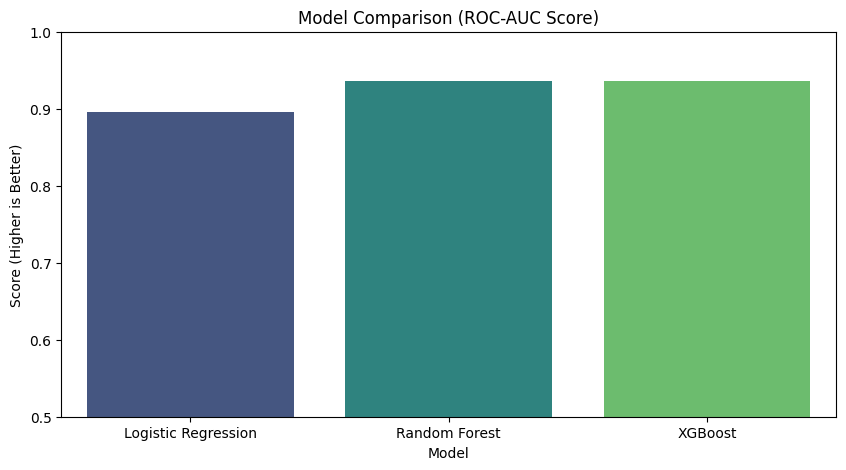

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.881756,0.895735
1,Random Forest,0.892029,0.935959
2,XGBoost,0.890933,0.935447


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. เตรียมข้อมูล X (Features) และ y (Target)
X = model_data.drop('seriousness', axis=1)
y = model_data['seriousness']

# 2. แบ่งข้อมูล: สอน 80% (Train), สอบ 20% (Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Test Set:     {X_test.shape}")
print("-" * 30)

# 3. ประกาศโมเดลผู้ท้าชิง
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 4. เริ่มการประลอง (Loop Train & Evaluate)
results = []

for name, model in models.items():
    print(f"🤖 Training {name}...")
    model.fit(X_train, y_train)
    
    # ทำนายข้อสอบ
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # เอาค่าความมั่นใจมาคำนวณ ROC
    
    # ตรวจคะแนน
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": roc})
    
    print(f"   -> Accuracy: {acc:.4f}")
    print(f"   -> ROC-AUC:  {roc:.4f}")
    print("-" * 30)

# 5. สรุปผลเป็นกราฟ
res_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=res_df, x="Model", y="ROC-AUC", palette="viridis")
plt.title("Model Comparison (ROC-AUC Score)")
plt.ylim(0.5, 1.0) # Zoom ดูช่วงคะแนน
plt.ylabel("Score (Higher is Better)")
plt.show()

display(res_df)

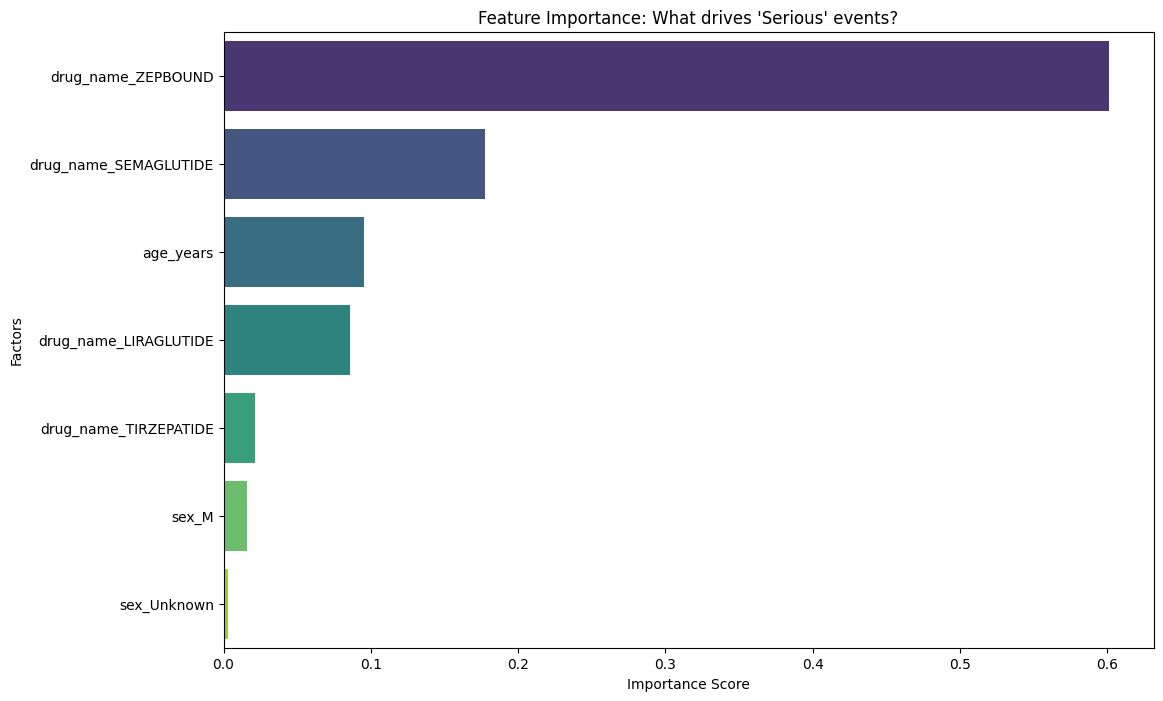

,Feature,Importance
6,drug_name_ZEPBOUND,0.601401
4,drug_name_SEMAGLUTIDE,0.177470
0,age_years,0.095262
3,drug_name_LIRAGLUTIDE,0.085708
5,drug_name_TIRZEPATIDE,0.021327
1,sex_M,0.015955
2,sex_Unknown,0.002877


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ดึงโมเดล Random Forest ที่เทรนไว้แล้ว (ตัวแปร models จากโค้ดที่แล้ว)
best_model = models["Random Forest"]

# 2. ดึงค่าความสำคัญ (Feature Importance)
importances = best_model.feature_importances_
feature_names = X.columns

# สร้าง DataFrame เพื่อจัดเรียง
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# เรียงลำดับจากมากไปน้อย
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# 3. พลอตกราฟ
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_df, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title("Feature Importance: What drives 'Serious' events?")
plt.xlabel("Importance Score")
plt.ylabel("Factors")
plt.show()

display(feature_df.head(10))

Features used: ['age_years', 'sex_M', 'sex_Unknown']


C:\Users\User\AppData\Local\Temp\ipykernel_29848\1206587218.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df_nd, x='Importance', y='Feature', palette='magma')


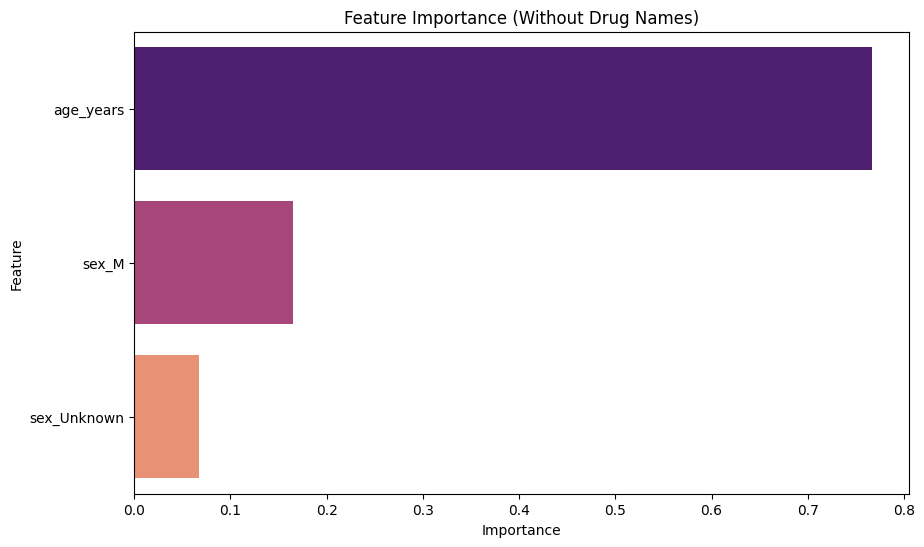

ROC-AUC (With Drugs):    0.9360
ROC-AUC (Without Drugs): 0.7209


In [9]:
# --- Experiment: Model without Drug Names ---

# 1. เลือก Feature เฉพาะ อายุ และ เพศ (ตัด Drug Name ทิ้ง)
# สังเกตว่าเรา drop columns ที่ขึ้นต้นด้วย 'drug_name_' ทั้งหมด
cols_to_drop = [col for col in X.columns if 'drug_name' in col]
X_no_drug = X.drop(columns=cols_to_drop)

print(f"Features used: {X_no_drug.columns.tolist()}")

# 2. แบ่ง Train/Test ใหม่
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_no_drug, y, test_size=0.2, random_state=42)

# 3. สร้างและเทรนโมเดลใหม่
rf_no_drug = RandomForestClassifier(n_estimators=100, random_state=42)
rf_no_drug.fit(X_train_nd, y_train_nd)

# 4. ดู Feature Importance ใหม่
importances_nd = rf_no_drug.feature_importances_
feature_df_nd = pd.DataFrame({'Feature': X_no_drug.columns, 'Importance': importances_nd}).sort_values(by='Importance', ascending=False)

# 5. พลอตกราฟ
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df_nd, x='Importance', y='Feature', palette='magma')
plt.title("Feature Importance (Without Drug Names)")
plt.show()

# 6. เช็คความแม่นยำ (ดูซิว่าพอไม่รู้ชื่อยาแล้ว ความแม่นจะตกไหม?)
from sklearn.metrics import roc_auc_score
y_prob_nd = rf_no_drug.predict_proba(X_test_nd)[:, 1]
print(f"ROC-AUC (With Drugs):    0.9360") # ค่าเดิมของคุณ
print(f"ROC-AUC (Without Drugs): {roc_auc_score(y_test_nd, y_prob_nd):.4f}")

🔧 Starting Hyperparameter Tuning (Grid Search)...
This may take a few minutes...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

🏆 Best Parameters Found:
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
🏆 Best Cross-Validation ROC-AUC: 0.9368

🏆 Best Parameters Found:
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
🏆 Best Cross-Validation ROC-AUC: 0.9368


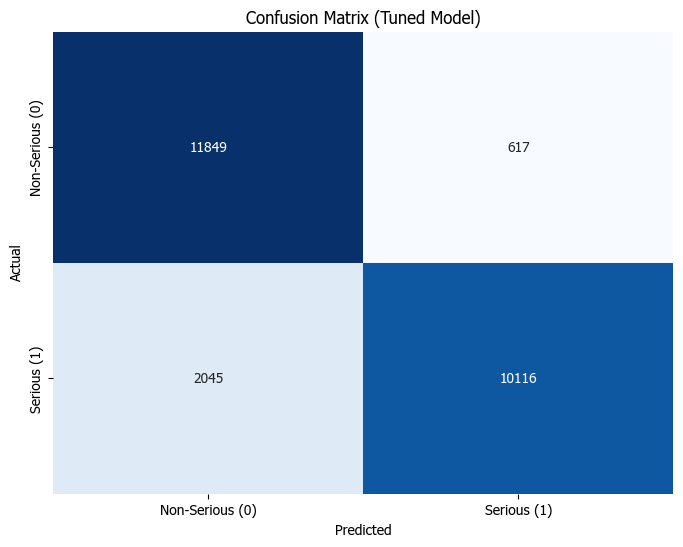


📊 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     12466
           1       0.94      0.83      0.88     12161

    accuracy                           0.89     24627
   macro avg       0.90      0.89      0.89     24627
weighted avg       0.90      0.89      0.89     24627



In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. กำหนด "พื้นที่ค้นหา" (Parameter Grid)
# เราจะลองปรับค่าต่างๆ ของ Random Forest ดูว่าค่าไหนเวิร์คสุด
param_grid = {
    'n_estimators': [100, 200],       # จำนวนต้นไม้ (ยิ่งเยอะยิ่งแม่น แต่ช้า)
    'max_depth': [10, 20, None],      # ความลึกสูงสุด (ลึกมากไปอาจ Overfit)
    'min_samples_split': [2, 5],      # จำนวนขั้นต่ำที่จะแตกกิ่ง
    'class_weight': ['balanced', None] # ปรับสมดุลน้ำหนัก (เผื่อข้อมูลเอียง)
}

print("🔧 Starting Hyperparameter Tuning (Grid Search)...")
print("This may take a few minutes...")

# 2. สร้าง Grid Search
# cv=3 แปลว่าแบ่งเทส 3 รอบ (Cross Validation)
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid,
                       cv=3,
                       n_jobs=-1, # ใช้ทุก CPU Core ช่วยคำนวณ
                       verbose=2,
                       scoring='roc_auc')

# 3. เริ่มค้นหา (Fit) - ใช้ X_train ตัวที่มีชื่อยา (Model A)
rf_grid.fit(X_train, y_train)

# 4. ดูผลลัพธ์ที่ดีที่สุด
best_params = rf_grid.best_params_
best_score = rf_grid.best_score_

print("\n🏆 Best Parameters Found:")
print(best_params)
print(f"🏆 Best Cross-Validation ROC-AUC: {best_score:.4f}")

# ---------------------------------------------------------
# 5. Evaluation (วัดผลโมเดลตัวเทพที่จูนแล้ว)
# ---------------------------------------------------------
best_rf = rf_grid.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Serious (0)', 'Serious (1)'])
plt.yticks([0.5, 1.5], ['Non-Serious (0)', 'Serious (1)'])
plt.show()

# Classification Report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred_tuned))

In [16]:
import joblib
import os

# 1. ดึงโมเดลที่ดีที่สุดจากการจูน (Best Estimator) ออกมา
# rf_grid คือตัวแปรที่คุณใช้รัน GridSearchCV ก่อนหน้านี้
best_rf_model = rf_grid.best_estimator_

print(f"🏆 Saving Best Model with params: {rf_grid.best_params_}")

# 2. สร้างโฟลเดอร์ models (ถ้ายังไม่มี)
os.makedirs("models", exist_ok=True)

# 3. บันทึกโมเดล (Save Model)
# เราจะบันทึกทับชื่อเดิม 'glp1_risk_predictor.pkl' เพื่อให้ App ดึงไปใช้ได้เลยโดยไม่ต้องแก้โค้ด App
model_path = 'models/glp1_risk_predictor.pkl'
joblib.dump(best_rf_model, model_path)
print(f"✅ Model saved to: {model_path}")

# 4. บันทึกรายชื่อคอลัมน์ (Save Columns)
# ต้องใช้ X_train ตัวเดียวกับที่ใช้เทรน (เพื่อให้ลำดับ Feature ตรงกัน)
columns_path = 'models/model_columns.pkl'
model_columns = list(X_train.columns)
joblib.dump(model_columns, columns_path)
print(f"✅ Feature columns saved to: {columns_path}")

print("\n🎉 Process Complete! The tuned model is ready for deployment.")

🏆 Saving Best Model with params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
✅ Model saved to: models/glp1_risk_predictor.pkl
✅ Feature columns saved to: models/model_columns.pkl

🎉 Process Complete! The tuned model is ready for deployment.


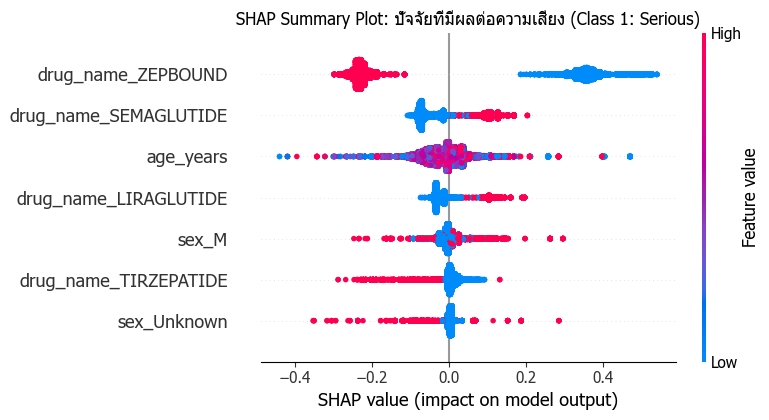

In [17]:
import shap
import matplotlib.pyplot as plt

# 1. เตรียมข้อมูลให้ตรงกับโมเดล (Reset X_test ให้มีชื่อยา)
# เราต้องใช้ X ตัวเต็มที่มีชื่อยา (จาก model_data)
X_full = model_data.drop('seriousness', axis=1)
y_full = model_data['seriousness']

# แบ่ง Train/Test ใหม่เพื่อให้ได้ X_test ตัวที่ถูกต้อง
from sklearn.model_selection import train_test_split
_, X_test_correct, _, _ = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# 2. คำนวณ SHAP Values ใหม่
# ใช้ TreeExplainer กับโมเดลที่ดีที่สุด
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_correct)

# 3. จัดการ Format ของ SHAP (แก้ Error Shape)
# ผลลัพธ์ของ SHAP สำหรับ Binary Classification มักจะมาเป็น list 2 ตัว [Class0, Class1]
# เราสนใจ Class 1 (Serious)
if isinstance(shap_values, list):
    vals_to_plot = shap_values[1]
else:
    # บางเวอร์ชั่นอาจคืนค่าเป็น 3D Array (n_samples, n_features, n_classes)
    if len(shap_values.shape) == 3:
        vals_to_plot = shap_values[:, :, 1]
    else:
        vals_to_plot = shap_values

# 4. วาดกราฟ (ใช้ X_test_correct ที่เตรียมมาใหม่)
plt.figure(figsize=(10, 6))

# ตั้งค่าฟอนต์ภาษาไทย (เลือกตัวใดตัวหนึ่ง)
plt.rcParams['font.family'] = 'Tahoma' 

# จากนั้นสั่ง plot ใหม่
plt.title("SHAP Summary Plot: ปัจจัยที่มีผลต่อความเสี่ยง (Class 1: Serious)")
shap.summary_plot(vals_to_plot, X_test_correct)